# Расчет коэффициентов пролонгации. Техническая реализация

### Шаг 1: Загрузка и предварительная обработка данных

In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset

In [2]:
df_prolongations = pd.read_csv('data/prolongations.csv')
df_financial = pd.read_csv('data/financial_data.csv')

#### 1.1. Преобразование финансовой таблицы в 'длинный' формат для удобства анализа временных рядов.

In [3]:
id_vars = ['id', 'Причина дубля', 'Account']

value_vars = [col for col in df_financial.columns if col not in id_vars]

df_financial_long = pd.melt(
    df_financial,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='shipment_month_str', # Новая колонка для названий месяцев
    value_name='shipment_amount'   # Новая колонка для сумм отгрузок
)

### Шаг 2: Очистка данных и обработка специальных значений

#### 2.1. Исключение досрочно остановленных проектов и обработка текстовых значений.

In [4]:

df_financial_long['shipment_amount'] = df_financial_long['shipment_amount'].replace('в ноль', -1)

df_financial_long['shipment_amount'] = df_financial_long['shipment_amount'].replace(['стоп', 'end'], np.nan)

# Находим уникальные ID всех проектов, у который сумма отгрузок NaN (т.е. мы еще и включаем случаи `стоп`/`end`)
stopped_projects = df_financial_long[df_financial_long['shipment_amount'].isna()]['id'].unique()

# Фильтруем датафрейм, удаляя все строки, относящиеся к этим ID
df_financial_long = df_financial_long[~df_financial_long['id'].isin(stopped_projects)]

In [5]:
# Преобразует строковое значение в число (float), очищая от пробелов и заменяя запятую.
def clean_value(value):
    if isinstance(value, str):
        value = value.replace('\xa0', '').replace(' ', '').replace(',', '.')
    try:
        return float(value)
    except (ValueError, TypeError):
        return 0.0

In [6]:
df_financial_long['shipment_amount'] = df_financial_long['shipment_amount'].apply(clean_value)

#### 2.2. Преобразование дат и обработка значений 'в ноль'.

In [7]:
# Преобразует текстовые даты в формат datetime
def convert_str_date_to_datetime(df, column_name):
    month_map = {'Январь':'01','Февраль':'02','Март':'03','Апрель':'04','Май':'05','Июнь':'06','Июль':'07','Август':'08','Сентябрь':'09','Октябрь':'10','Ноябрь':'11','Декабрь':'12'}
    
    date_series = df[column_name].str.split(' ')
    date_str_normalized = ('01-' + date_series.str[0].str.capitalize().map(month_map) + '-' + date_series.str[1])

    df[column_name] = pd.to_datetime(date_str_normalized, format='%d-%m-%Y', errors='coerce')
    
    return df

In [8]:
df_financial_long = convert_str_date_to_datetime(df_financial_long, 'shipment_month_str')
df_prolongations = convert_str_date_to_datetime(df_prolongations, 'month')

In [9]:
df_financial_long = df_financial_long.sort_values(by=['id', 'shipment_month_str'])

# Заполняем маркеры -1 ('в ноль') предыдущим значением внутри группы каждого проекта
df_financial_long['shipment_amount'] = df_financial_long.groupby('id')['shipment_amount'].transform(
    lambda x: x.replace(-1, method='ffill')
)

# Если маркер -1 остался (например, в самом первом месяце проекта), заменяем его на 0
df_financial_long['shipment_amount'] = df_financial_long['shipment_amount'].replace(-1, 0)

C:\Users\scarl\AppData\Local\Temp\ipykernel_11504\1474639829.py:5: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  lambda x: x.replace(-1, method='ffill')


### Шаг 3: Агрегация и финальная подготовка таблицы

Объединяем данные и суммируем все отгрузки по проекту за месяц, чтобы получить единую, готовую к расчетам таблицу.

In [10]:
df_merged = pd.merge(
    df_prolongations,
    df_financial_long,
    on='id',
    how='inner'
)

In [11]:
df_clean = df_merged.drop(columns=['Account', 'Причина дубля'])

df_agg = df_clean.groupby(['id', 'AM', 'shipment_month_str', 'month'])['shipment_amount'].sum().reset_index()

df_cleanest = df_agg.rename(columns={
    'id': 'project_id',
    'AM': 'account_manager',
    'month': 'project_end_month', # Последний месяц реализации проекта
    'shipment_month_str': 'shipment_month', # Месяц, за который произведена отгрузка
    'shipment_amount': 'shipment_sum' # Сумма отгрузки
})

In [12]:
df_cleanest.head()

,project_id,account_manager,shipment_month,project_end_month,shipment_sum
0,190,Васильев Артем Александрович,2022-11-01,2023-02-01,149080.0
1,190,Васильев Артем Александрович,2022-11-01,2023-12-01,149080.0
2,190,Васильев Артем Александрович,2022-12-01,2023-02-01,149100.0
3,190,Васильев Артем Александрович,2022-12-01,2023-12-01,149100.0
4,190,Васильев Артем Александрович,2023-01-01,2023-02-01,177595.0


### Шаг 4: Расчет коэффициентов

Реализация основного цикла для итеративного расчета К1 и К2.

In [14]:
managers = df_cleanest['account_manager'].unique().tolist()
all_managers_label = 'Весь отдел'
managers_and_total = managers + [all_managers_label]

report_months = pd.to_datetime([f'2023-{i}-01' for i in range(1, 13)])

results = []

Сам цикл:

In [15]:
for manager in managers_and_total:
    
    if manager == all_managers_label:
        manager_df = df_cleanest
    else:
        manager_df = df_cleanest[df_cleanest['account_manager'] == manager]

    total_k1_numerator, total_k1_denominator = 0, 0
    total_k2_numerator, total_k2_denominator = 0, 0

    for current_month in report_months:

        prev_month = current_month - DateOffset(months=1)
        
        # Знаменатель K1: Находим проекты, завершившиеся в прошлом месяце. 
        # Это и есть наша база для пролонгации.
        k1_base_df = manager_df[
            (manager_df['project_end_month'] == prev_month) &
            (manager_df['shipment_month'] == prev_month)
        ]
        # Сумма отгрузки по этим проектам за их последний месяц
        k1_denominator = k1_base_df['shipment_sum'].sum()
        
        # Числитель K1: Для этих же проектов смотрим их отгрузку в текущем месяце
        k1_prolonged_project_ids = k1_base_df['project_id'].unique()
        k1_numerator = manager_df[
            (manager_df['project_id'].isin(k1_prolonged_project_ids)) &
            (manager_df['shipment_month'] == current_month)
        ]['shipment_sum'].sum()

        # Расчет метрики "База для пролонгации"
        base_for_prolongation_sum = k1_denominator
        base_for_prolongation_count = k1_base_df['project_id'].nunique()
        
        # Сохраняем результат по базе в наш список
        results.append({
            'Менеджер': manager,
            'Метрика': 'База для пролонгации (сумма)',
            'Месяц': current_month,
            'Значение': base_for_prolongation_sum
        })
        results.append({
            'Менеджер': manager,
            'Метрика': 'База для пролонгации (кол-во)',
            'Месяц': current_month,
            'Значение': base_for_prolongation_count
        })
        
        month_minus_2 = current_month - DateOffset(months=2)

        # Знаменатель К2: Проекты, завершившиеся 2 месяца назад и НЕ продленные на 1-й месяц
        ended_m2_ids = manager_df[manager_df['project_end_month'] == month_minus_2]['project_id'].unique()
        prolonged_in_1st_month_ids = manager_df[
            (manager_df['project_id'].isin(ended_m2_ids)) &
            (manager_df['shipment_month'] == prev_month) &
            (manager_df['shipment_sum'] > 0)
        ]['project_id'].unique()
        k2_base_project_ids = np.setdiff1d(ended_m2_ids, prolonged_in_1st_month_ids)
        k2_denominator = manager_df[
            (manager_df['project_id'].isin(k2_base_project_ids)) &
            (manager_df['shipment_month'] == month_minus_2)
        ]['shipment_sum'].sum()

        # Числитель К2: Для этих же проектов ищем отгрузку в текущем месяце
        k2_numerator = manager_df[
            (manager_df['project_id'].isin(k2_base_project_ids)) &
            (manager_df['shipment_month'] == current_month)
        ]['shipment_sum'].sum()

        k1 = k1_numerator / k1_denominator if k1_denominator > 0 else 0
        k2 = k2_numerator / k2_denominator if k2_denominator > 0 else 0
        
        results.append({
            'Менеджер': manager,
            'Метрика': 'Коэффициент 1',
            'Месяц': current_month,
            'Значение': k1
        })
        results.append({
            'Менеджер': manager,
            'Метрика': 'Коэффициент 2',
            'Месяц': current_month,
            'Значение': k2
        })

        # Добавляем месячные суммы к годовым
        total_k1_numerator += k1_numerator
        total_k1_denominator += k1_denominator
        total_k2_numerator += k2_numerator
        total_k2_denominator += k2_denominator
    
    # Рассчитываем и сохраняем годовые коэффициенты
    annual_k1 = total_k1_numerator / total_k1_denominator if total_k1_denominator > 0 else 0
    annual_k2 = total_k2_numerator / total_k2_denominator if total_k2_denominator > 0 else 0

    results.append({
        'Менеджер': manager,
        'Метрика': 'Коэффициент 1 (Год)',
        'Месяц': 'Годовой',
        'Значение': annual_k1
    })
    results.append({
        'Менеджер': manager,
        'Метрика': 'Коэффициент 2 (Год)',
        'Месяц': 'Годовой',
        'Значение': annual_k2
    })
    results.append({
        'Менеджер': manager,
        'Метрика': 'База для пролонгации (сумма, Год)',
        'Месяц': 'Годовой',
        'Значение': total_k1_denominator
    })

### Шаг 5: Формирование и экспорт отчета в Excel

Сводим полученные результаты в таблицу и выгружаем в Excel-файл

In [16]:
results_df = pd.DataFrame(results)

file_name = 'analytical_report.xlsx'
with pd.ExcelWriter(f'data/{file_name}', engine='xlsxwriter') as writer:
    results_df.to_excel(writer, sheet_name='Коэффициенты пролонгации', merge_cells=True)
    
    workbook = writer.book
    worksheet = writer.sheets['Коэффициенты пролонгации']

### Шаг 6: Визуализация данных для отчета

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [18]:
sns.set_theme(style="whitegrid")

Отфильтруем данные только для Коэффициента 1 и уберем годовые итоги

In [19]:
k1_monthly_df = results_df[
    (results_df['Метрика'] == 'Коэффициент 1') &
    (results_df['Месяц'] != 'Годовой')
].copy()

k1_monthly_df['Месяц'] = pd.to_datetime(k1_monthly_df['Месяц'])

Отфильтруем данные для годового рейтинга по Коэффициенту 1

In [20]:
k1_yearly_df = results_df[
    (results_df['Метрика'] == 'Коэффициент 1 (Год)') &
    (results_df['Менеджер'] != 'Весь отдел')
].sort_values('Значение', ascending=False)

Создание дашборда из двух графиков

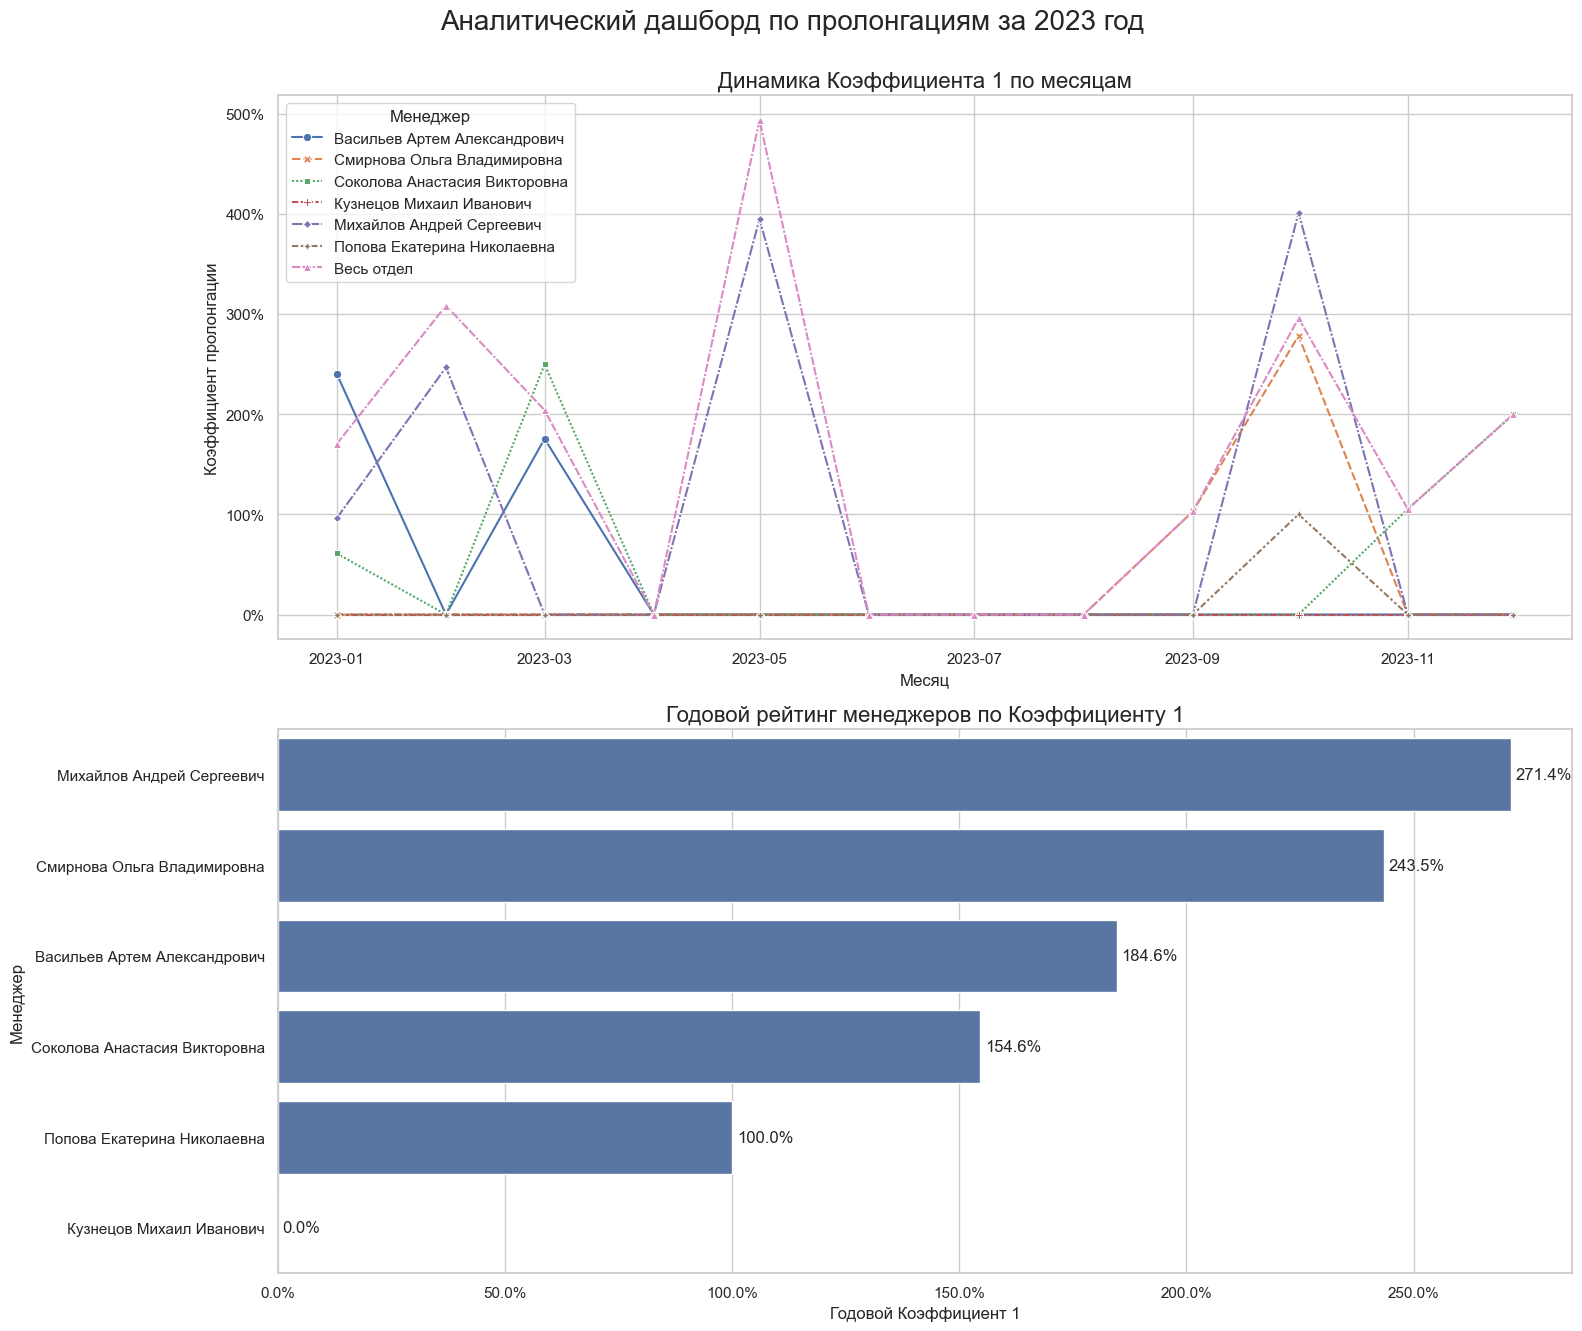

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(16, 14))
fig.suptitle('Аналитический дашборд по пролонгациям за 2023 год', fontsize=20, y=0.95)

# График A: Динамика Коэффициента 1 по месяцам

ax1 = sns.lineplot(
    data=k1_monthly_df,
    x='Месяц',
    y='Значение',
    hue='Менеджер', # Разделяем на линии по менеджерам
    style='Менеджер', # Используем разные стили линий для лучшей читаемости
    markers=True, # Добавляем маркеры на точки данных
    dashes=True,
    ax=axes[0] # Размещаем на верхней части сетки
)

# Настройка верхнего графика
ax1.set_title('Динамика Коэффициента 1 по месяцам', fontsize=16)
ax1.set_xlabel('Месяц')
ax1.set_ylabel('Коэффициент пролонгации')
# Форматируем ось Y в проценты
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax1.legend(title='Менеджер')

# График Б: Годовой рейтинг менеджеров

ax2 = sns.barplot(
    data=k1_yearly_df,
    x='Значение',
    y='Менеджер',
    orient='h', # Гориентируем график горизонтально
    ax=axes[1] # Размещаем на нижней части сетки
)

# Настройка нижнего графика
ax2.set_title('Годовой рейтинг менеджеров по Коэффициенту 1', fontsize=16)
ax2.set_xlabel('Годовой Коэффициент 1')
ax2.set_ylabel('Менеджер')
# Форматируем ось X в проценты
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))

# Добавляем значения на столбцы гистограммы для наглядности
for p in ax2.patches:
    width = p.get_width()
    ax2.text(width + 0.01, # небольшое смещение от конца столбца
             p.get_y() + p.get_height() / 2,
             f'{width:.1%}', # форматируем значение как процент
             va='center')
    
# Автоматически корректируем расположение элементов, чтобы они не накладывались
plt.tight_layout(rect=[0, 0, 1, 0.95])

dashboard_filename = 'prolongation_dashboard.png'
plt.savefig(dashboard_filename, dpi=300, bbox_inches='tight')

plt.show()